Q1

In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pdb
from copy import deepcopy

path_gpx = 'dataset/gp_x.csv'
path_gpt = 'dataset/gp_t.csv'
path_x = 'dataset/x_train.csv'
path_t = 'dataset/t_train.csv'

gp_x = pd.read_csv(path_gpx)
gp_t = pd.read_csv(path_gpt)
data_x = pd.read_csv(path_x)
data_t = pd.read_csv(path_t)

class GaussianProcess:
    def __init__(self, beta_inv, theta):
        self.beta_inv = beta_inv
        self.theta = theta

    
    # eq.6.63 @ p307
    def kernel(self, x_n, x_m):
        return self.theta[0] * np.exp(-0.5 * self.theta[1] * np.subtract.outer(x_n, x_m) **2) \
                + self.theta[2] + self.theta[3] * np.multiply.outer(x_n, x_m)
    
    def fit(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train
        
        # eq6.62
        C = self.kernel(x_train, x_train) + beta_inv * np.eye(x_train.shape[0])
        self.C_inv = np.linalg.inv(C)
    
    
    def predict(self, x):
        self.x_test = x 
        
        # eq6.65 @ p308
        self.C = self.kernel(x, x) + beta_inv # scalar c (小c) -> ask why not scalar
        k = self.kernel(self.x_train, x)# test k
        cov = self.C - np.linalg.multi_dot([k.T, self.C_inv, k]) # eq.6.67

        # eq6.66 
        mean = np.linalg.multi_dot([k.T, self.C_inv, self.t_train])
        std = np.sqrt(np.diag(cov)) 
        # pdb.set_trace()
        
        return mean, std
                
    def theta_diff(self, term): # calculate differientiation
        outer_minus = np.subtract.outer(self.x_train, self.x_train)
        if term == 0:  
            return np.exp(-0.5 * self.theta[1]*(outer_minus**2))
        elif term == 1: 
            return self.theta[0] * -0.5 * outer_minus * \
                np.exp(-0.5 * self.theta[1] * outer_minus ** 2)
        elif term == 2: 
            return np.ones((len(self.x_train), len(self.x_train)))
        else: 
            return np.multiply.outer(self.x_train, self.x_train)

    
    def log_likelihood(self, td):
        return -0.5 * np.trace(self.C_inv.dot(td)) + \
        0.5 * np.linalg.multi_dot([self.t_train.T, self.C_inv, td, self.C_inv, self.t_train])

    # p313
    def ard(self, lr , thres):
        epoch = 0
        store_thetas = self.theta
        update = np.zeros((4,1))
        
        while True:
            epoch += 1
            for i in range(4): # in each theta params
                #print(self.theta_diff(i))
                update[i] = self.log_likelihood(self.theta_diff(i))
#             print(self.C_inv)
                
            # pdb.set_trace()
            new_theta = np.array(self.theta).reshape(-1,1) + lr * update
            self.theta = new_theta.reshape(-1).tolist()
            
            store_thetas.append(self.theta)
            
            print(f'epoch {epoch}: theta{self.theta}')
            # pdb.set_trace()
            self.C_inv = np.linalg.inv(self.kernel(self.x_train, self.x_train) + \
            beta_inv * np.eye(self.x_train.shape[0]))
            
            
            if max(np.absolute(update)) < thres or epoch == 100:
                print('terminates')
                break;    
        return store_thetas


In [11]:
def RMS(y, t):
    return np.sqrt(np.mean((y - t) ** 2)) 


def plotGP():
    x_axis = np.linspace(0, 1, 1000) # the x_axis of the line
    mean, std = model.predict(x_axis)
    
    plt.figure()
    plt.title(f'theta = {THETA}')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.plot(x_axis, mean,'-', c='black', label='prediction')
    plt.fill_between(x_axis, mean + std, mean - std, alpha=0.5, color='grey')
    plt.scatter(train_gpx, train_gpt, c='b',label='train data')
    plt.legend(loc='best')
    plt.show()
    return 0

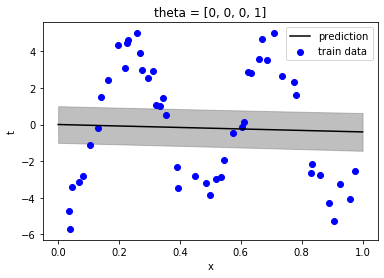

Train RMSE: 3.17119
Test RMSE: 3.30463


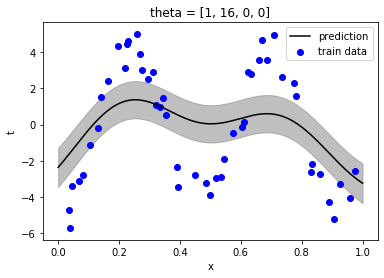

Train RMSE: 2.43623
Test RMSE: 2.6503


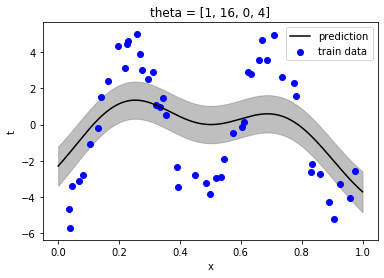

Train RMSE: 2.42429
Test RMSE: 2.63986
ard start
epoch 1: theta[2.8774413975246476, 64.0, 31.999249190761418, -0.009112257608700746]
epoch 2: theta[3.1687252650607216, 64.0, 31.99851226909017, -0.012154800771149511]
epoch 3: theta[3.410041340675923, 64.0, 31.997776895813157, -0.014940667376110958]
epoch 4: theta[3.618675658458601, 64.0, 31.997042769753065, -0.017551018024282765]
epoch 5: theta[3.8038525466388173, 64.0, 31.996309701485107, -0.020030585308520685]
epoch 6: theta[3.971181764395153, 64.0, 31.995577558778514, -0.022407330281923828]
epoch 7: theta[4.124372640375521, 64.0, 31.994846243101104, -0.02470019513928589]
epoch 8: theta[4.266026189155018, 64.0, 31.99411567765488, -0.02692275654127981]
epoch 9: theta[4.398047681436458, 64.0, 31.993385800578146, -0.02908516163454048]
epoch 10: theta[4.521880801009429, 64.0, 31.992656560769838, -0.031195244205293925]
epoch 11: theta[4.638649474961518, 64.0, 31.99192791516963, -0.03325921056024998]
epoch 12: theta[4.7492482912271505, 64.0

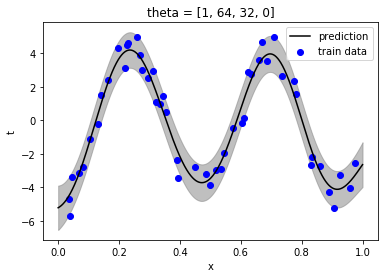

Train RMSE: 0.68767
Test RMSE: 1.05566


In [12]:

# data preprocess
train_gpx = np.array(gp_x[:50]).reshape(-1)
train_gpt = np.array(gp_t[:50]).reshape(-1)
test_gpx = np.array(gp_x[50:]).reshape(-1)
test_gpt = np.array(gp_t[50:]).reshape(-1)

#hyperparameters
theta_ls = [[0, 0, 0, 1], [1, 16, 0, 0], [1, 16, 0, 4], [1, 64, 32 , 0]] 
beta_inv = 1
lr = 5 * 1e-2
thres = 1

#%%
for THETA in theta_ls:

    # Generate Gaussian process model
    model = GaussianProcess(beta_inv, deepcopy(THETA))
    
    # Fit training data
    model.fit(train_gpx, train_gpt)
    
    if THETA ==[1, 64, 32, 0]:     
        print('ard start')
        store_thetas = model.ard(lr, thres)
    
    # Plot prediction
    plotGP()
    
    # RMSE
    mean_train, _ = model.predict(train_gpx)
    rms_train = RMS(mean_train, train_gpt)
    
    mean_test, _ = model.predict(test_gpx)
    rms_test = RMS(mean_test, test_gpt)
    
    print(f'Train RMSE: {round(rms_train,5)}')
    print(f'Test RMSE: {round(rms_test,5)}')

[1, 64, 32, 0]


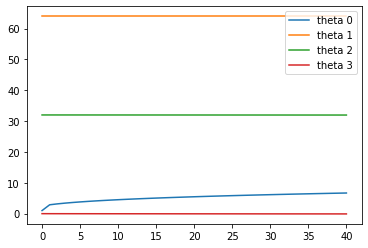

In [13]:
print(THETA)
# print(.shape)
origin_theta = np.array(THETA).reshape(1, -1)

store_thetas = np.array(store_thetas[4:])
plot_thetas = np.concatenate((origin_theta, store_thetas), axis=0)

plt.figure()
plt.plot(plot_thetas[:,0], label='theta 0')
plt.plot(plot_thetas[:,1], label='theta 1')
plt.plot(plot_thetas[:,2], label='theta 2')
plt.plot(plot_thetas[:,3], label='theta 3')
plt.legend(loc='best')

Q2

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from collections import Counter
import math
import pdb
path_x = 'dataset/x_train.csv'
path_t = 'dataset/t_train.csv'

In [15]:
def PCA(x, dim):
    N = x.shape[0]
    
    mean = np.mean(x, axis = 0)
    B = x - np.tile(mean, (N,1))
    cov = np.dot(B.T, B) / (N - 1) #(feature shape, feature shape)
    D, V = np.linalg.eigh(cov)
    
    idx = np.argsort(D)[::-1] # from big to small eigen values idx
    D2 = D[idx]
    V2 = V[:,idx]
    x = np.dot(x, V2[:, :dim])
    x = normalize(x)
    
    return x

def normalize(x):
    return (x - np.mean(x)) / np.std(x)

class SVM:
    def __init__(self, phi, decision):
        self.phi = phi
        self.decision = decision
        self.classes = [[0, 1], [0, 2], [1, 2]]

    def get_phi(self, x):
        if self.phi == 'linear':
            return x
        
        # input (N, 2)
        x = x.reshape((-1, 2))
        x_1 = x[:, 0]
        x_2 = x[:, 1]
        
        # output(3,)
        if x.shape[0] == 1:
            return np.array([x_1 ** 2, np.sqrt(2) * x_1 * x_2, x_2 ** 2]).T.reshape((-1))
        
        # output (N, 3)
        return np.array([x_1 ** 2, np.sqrt(2) * x_1 * x_2, x_2 ** 2]).T

    
    def kernel(self, x_i, x_j):
        return np.dot(self.get_phi(x_i), self.get_phi(x_j).T)
    
    def fit(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train
        
        clf = SVC(kernel=self.kernel, decision_function_shape=self.decision)
        clf.fit(x_train, t_train)
        self.coef = np.abs(clf.dual_coef_)
        self.sv_index = clf.support_
        
        self._set_multipliers()
        self._set_weights()
        self._set_biases()
        
    def predict(self, x_test):
        prediction = []
        for i in range(x_test.shape[0]):
            votes = []
            for j in range(3):
                y = self.weights[j].dot(self.get_phi(x_test[i])) + self.biases[j]
                if y > 0:
                    votes.append(self.classes[j][0])
                else:
                    votes.append(self.classes[j][1])
            prediction.append(Counter(votes).most_common()[0][0])
        return np.array(prediction)

    def _set_multipliers(self):
        
        multiplier = np.zeros((self.x_train.shape[0], 2))
        multiplier[self.sv_index] = self.coef.T
        
        self.t = []
        for c in self.classes:
            target = np.zeros(t_train.shape)
            target[t_train == c[0]] = 1
            target[t_train == c[1]] = -1
            self.t.append(target)
                
        a_0_1 = np.zeros(t_train.shape)
        a_0_1[t_train == 0] = multiplier[t_train == 0, 0]
        a_0_1[t_train == 1] = multiplier[t_train == 1, 0]
        
        a_0_2 = np.zeros(t_train.shape)
        a_0_2[t_train == 0] = multiplier[t_train == 0, 1]
        a_0_2[t_train == 2] = multiplier[t_train == 2, 0]
        
        a_1_2 = np.zeros(t_train.shape)
        a_1_2[t_train == 1] = multiplier[t_train == 1, 1]
        a_1_2[t_train == 2] = multiplier[t_train == 2, 1]
        
        self.a = [a_0_1, a_0_2, a_1_2]
    
    def _set_weights(self):
        self.weights = [self._weight(self.a[i], self.t[i], x_train) for i in range(3)]
        
    def _set_biases(self):
        self.biases = [self._bias2(self.a[i], self.t[i], x_train) for i in range(3)]
    
    def _weight(self, a, t, X):
        at = a * t
        w = np.dot(at, self.get_phi(X))
        return w
    
    def _bias2(self, a, t, X):
        S = a != 0
        b = 0
        for n in np.where(S)[0]:
            temp = 0
            for m in np.where(S)[0]:
                temp += a[m] * t[m] * self.kernel(X[n], X[m])
            b += t[n] - temp
        b /= np.sum(S)
        return b
    
    def _bias(self, a, t, X):
        M = np.logical_and(a > 0, a < 1)
        if np.sum(M) == 0: return -1
        S = a != 0
        b = 0
        for n in np.where(M)[0]:
            temp = 0
            for m in np.where(S)[0]:
                temp += a[m] * t[m] * self.kernel(X[n], X[m])
            b += t[n] - temp
        b /= np.sum(M)
        return b

    def plot_result(self, X, t):
        
        plt.figure()
        plt.title(f'decision type: {self.decision} phi = {self.phi}')
        plt.scatter(X[self.sv_index, 0], X[self.sv_index, 1], facecolors='none', edgecolors='k', linewidths=2, label="support vector")
        plt.scatter(X[t == 0, 0], X[t == 0, 1], c='b', marker='x', label="class 0")
        plt.scatter(X[t == 1, 0], X[t == 1, 1], c='g', marker='x', label="class 1")
        plt.scatter(X[t == 2, 0], X[t == 2, 1], c='r', marker='x', label="class 2")
        plt.legend(loc='best')
        
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                             np.arange(y_min, y_max, 0.005))
        pred = self.predict(np.column_stack((xx.flatten(), yy.flatten())))
        plt.contourf(xx, yy, pred.reshape(xx.shape), alpha=0.1, cmap=plt.cm.coolwarm)
        plt.show()



In [16]:
data_x = pd.read_csv(path_x)
data_t = pd.read_csv(path_t)

data_x = np.array(data_x)
data_t = np.array(data_t).reshape(-1)


print(data_x.shape)
print(data_t.shape)
# print(x_train.mean())


# x_train = np.loadtxt(path_x, delimiter=',')
# t_train = np.loadtxt(path_t, delimiter=',')
# print(x_train.shape)
# print(t_train.shape)

(299, 784)
(299,)


In [17]:
x_train = PCA(data_x, dim=2)
t_train = data_t
print(x_train.shape)
print(x_train.shape)

(299, 2)
(299, 2)


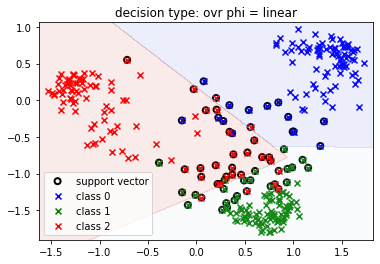

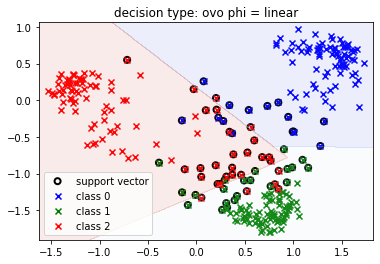

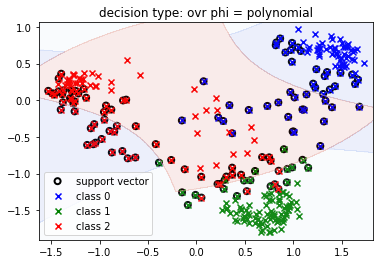

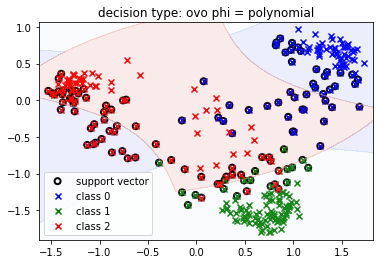

In [18]:
# hyperparameters
phi_ls = ['linear', 'polynomial']
decision_ls = ['ovr','ovo']

for PHI in phi_ls:
    for DECISION in decision_ls:
        svm = SVM(phi=PHI, decision=DECISION) 
        svm.fit(x_train, t_train)
        svm.plot_result(x_train, t_train)
        

Q3

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from collections import Counter
import pdb
from PIL import Image
from scipy.stats import multivariate_normal
import random
path_gmm = 'dataset/imghw3.jpg'
save_path = 'dataset/GMM/'

In [20]:
def KMeans(data, K, epoch):
    
    N = data.shape[0]
    idx = np.array(random.sample(range(N),K)) 
    mu = data[idx] # random select a sample as center
    r_map = np.eye(K)
    data = data.reshape((-1, 1, 3)) # 3 = RGB 
    # pdb.set_trace()
    e = 0
    
    while True:
        # pdb.set_trace()
        distance = np.sum((data - mu) ** 2, axis = 2) # (76480, 5) 
        label = np.argmin(distance, axis = 1)
        r_nk = r_map[label].reshape((-1, K, 1)) # (76480, k, 1)
        
        # mu shape = (k, 3); get new mean 
        mu_new = np.sum(r_nk * data, axis=0) / np.sum(r_nk)
        
        # terminal points
        if (mu.all() == mu_new.all()) or e > epoch: break
        else: mu = mu_new
        e += 1
    return mu, r_nk


def EM(data, r_nk, mu, K, epoch):
    likelihood_history = []
    pi, cov, likelihoods = initialize(data, r_nk, mu, K)
    for it in range(epoch):
        gamma = E_step(likelihoods)
        pi, mu, cov = M_step(data, gamma, K)
        likelihoods = evaulate(data, pi, mu, cov, K)
        likelihood_history.append(log_likelihood(likelihoods))
    return mu, likelihoods, likelihood_history

def initialize(data, r_nk, mu, K):
    # pi = (K, 1)
    pi = np.sum(r_nk, axis = 0) / r_nk.shape[0]
    # cov = (K, 3, 3)
    cov = [np.cov(data[np.where(r_nk[:, k] == 1)[0]].T) for k in range(K)]
    # evaulate initial likelihood = (K, N)
    likelihoods = evaulate(data, pi, mu, cov, K)
    return pi, cov, likelihoods

def E_step(likelihoods): # cal gamma
    # gamma = (N, K)
    return (likelihoods / np.sum(likelihoods, axis = 0)).T

def M_step(data, gamma, K):
    gamma = gamma.reshape((-1, K, 1))
    data = data.reshape((-1, 1, 3))
    
    N = np.sum(gamma, axis=0)
    mu_new = np.sum(gamma * data, axis=0) / N
    cov_new = []
    for k in range(K):
        x = (data - mu[k]).reshape((-1, 3))
        cov_new_k = np.dot((gamma[:, k] * x).T, x) / N[k]
        cov_new.append(cov_new_k)
    pi_new = N / data.shape[0]
    
    return pi_new, mu_new, cov_new
    
def evaulate(data, pi, mu, cov, K):
    likelihoods = np.array([pi[k] * multivariate_normal.pdf(data, mean = mu[k], cov = cov[k]) for k in range(K)])
    return likelihoods

def log_likelihood(likelihood):
    return np.sum(np.log(np.sum(likelihood, axis = 0)))    

In [21]:
def getImg(arr):
    arr = (arr * 255)
    arr = arr.reshape(data_shape)
    arr = arr.astype('uint8')
    img = Image.fromarray(arr)
    return img

def plot_liklihood(store_liklihood, K_ls):

    plt.figure()
    plt.title(f'GMM K = {K_ls}')
    for i in range(4):
        plt.plot(range(100), store_liklihood[i], label=f'K = {K_ls[i]}')
    plt.xlabel('epoch')
    plt.ylabel('logliklihood')
    plt.legend()
    plt.show()
    return 0

original pic


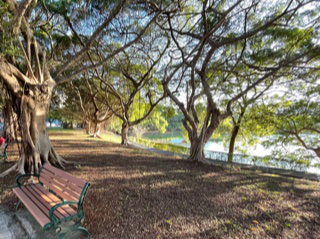

In [22]:
img = Image.open(path_gmm)
print(f'original pic')
display(img)
data = np.array(img)
data_shape = data.shape # (239, 320, 3)
data = data.reshape((-1, 3))
# normalize
data = data / 255


> <ipython-input-23-d60d9a5547a7>(8)<module>()
-> print(f'K-means K = {K}')
(Pdb) c
K-means K = 3
[[ 40.  41.   9.]
 [ 97.  94.  85.]
 [176. 185. 158.]]


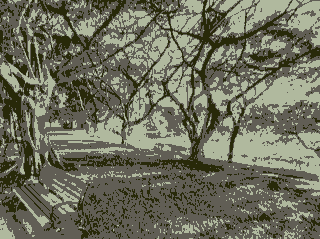

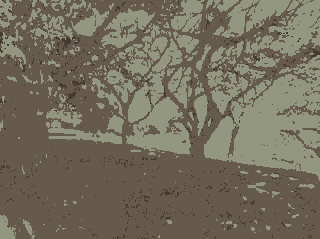

> <ipython-input-23-d60d9a5547a7>(7)<module>()
-> pdb.set_trace()
(Pdb) q


BdbQuit: 

In [23]:
K_ls = [3, 5, 7, 10]
epoch = 100
store_liklihood = []
for K in K_ls:
    
    mu, r_nk = KMeans(data, K, epoch)
    pdb.set_trace()
    print(f'K-means K = {K}')
    print(np.rint(mu * 255))
    
    img_kmeans = getImg(mu[np.where(r_nk == 1)[1]])
    # img_kmeans.save(save_path + f'kmeans_k={K}.jpg')
    display(img_kmeans)
    
    mu, likelihoods, likelihood_history = EM(data, r_nk, mu, K, epoch)
    store_liklihood.append(likelihood_history) # store likelihood to plot later
    
    img_gmm = getImg(mu[np.argmax(likelihoods, axis=0)])
    # img_gmm.save(save_path + f'gmm_k={K}.jpg')
    display(img_gmm)

# plot liklihood func.
plot_liklihood(store_liklihood, K_ls)   